
## **Question : 1** 


 **Linear Least Squares** **[5 points]**


The simplest model to predict the spread of infectious diseases is the SIR model. This model is a set of ordinary differential equations that describe the evolution of the number of susceptible (S(t)), infected (I(t)) and recovered/removed (R(t)) populations in a closed system. The equations are

$\frac{dS}{dt} = \frac {−βIS} {N} $, (1)

$\frac{dI}{dt} =\frac {βIS} {N} −γI$, (2)

$\frac{dR}{dt} = γI$, (3)

where $N = S(t)+I(t)+R(t)$. The basic reproduction number $R_0 = β/γ$ is defined to quantify the new infections that one infected person causes and is considered as a magic number to identify if an infectious disease is under control. For example, if $R_0 > 1$, the disease has an exponential growth whereas if $R_0 < 1$, the disease is under control and the infectious population will eventually go to zero. At peak $R_0$ will cross 1.
As with simple models, there exist analytical solutions to the SIR model. One form of the solution is given as

$S(t) = S(0) exp(−χ(t))$ , (4)

$I(t) = N − S(t) − R(t)$ , (5)

$R(t) = R(0) + ρχ(t)$ , (6)

$χ(t) = \frac {β} {N} \int_{0}^{t}I(t^*) dt^*$. (7)


For this assignment, we will consider a time unit of days, total population of India as 130 crores and the time horizon of interest as March 23, 2020 to Oct 15, 2020. Removed is a sum of recovered and deceased, i.e., the population that will not get infected again. Data in CSV form for state-wise-daily is available at
https://data.covid19india.org/csv/latest/state_wise_daily.csv

1. Download the state wise daily data of infected, recovered and deceased from the covid19india website. The data gives daily new infections, recovery and deceased. Use Pandas and create time-series of all India $I(t), S(t)$ and $R(t)$. Plot these time- series. Hint: Apply yourself and see what $I(t)$ means and what the data provides.
2. Formulate the problem of estimating $γ$ and $β$ as a linear least squares problem.
3. Form the Jacobian matrix and calculate its rank and condition number.
4. Form the coefficient matrix and calculate its condition number. Find the relation between this condition number and condition number of the Jacobian.
5. Code the cholesky factorization approach to solve the linear least squares problem.
6. Apply your code and estimate $β, γ$ and $R_0$.
7. Use scipy.optimize and estimate $β, γ$ and $R_0$.
8. State your observations in the above two items and give reasons.
9. Estimate $R_0(t)$ as a function of time by utilizing data until t to estimate the different parameters. Plot $R_0(t)$. 
10. Based on the above analyse the state of the pandemic in India. Has the peak passed as on Oct 2020?

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

POPULATION = 130 * (10**7)

df = pd.read_csv('./data/state_wise_daily.csv')
summed_data = df.sum(axis=1,numeric_only=True)   # Sum up along rows

#### Formula Used

- S(1) = Initial_population - Infected count from csv on day 1
- R(1) = Recovered count from csv on day 1
- I(1) = Infected count from csv on day 1 - R(1)

Further on
- S(t) = S(t-1) - Infected count from csv on day t
- R(t) = R(t-1) + Recovered count from csv on day t
- I(t) = I(t-1) + ( Infected count from csv on day t - Recovered count on day t)

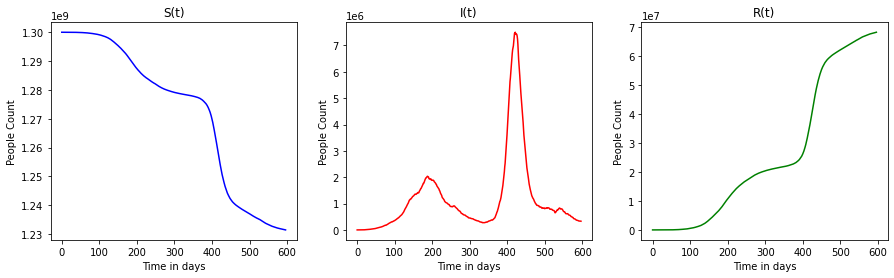

In [7]:
def get_susceptible_infected_recovered(data_frame):
    
    
    infected_indices = [3*i for i in range(int(len(data_frame)/3))]
    recovered_indices = [ 3*i+1 for i in range(int(len(data_frame)/3)) ]  # Add indices of Recovered
    recovered_indices =  recovered_indices +  [ 3*i+2 for i in range(int(len(data_frame)/3)) ] # Add indices of Decesesed
    recovered_indices = sorted(recovered_indices) 

    recovered_deceased = summed_data[recovered_indices]  # Get only rows related to recovered and deceased
    recovered_dup = recovered_deceased.groupby(recovered_deceased.index//3).transform('sum')
    rec_indices = [ 3*i + 1 for i in range(int(len(recovered_dup)//2))]
    

    recovered = recovered_dup[rec_indices]
    recovered = recovered.reset_index(drop = True)
    infected = summed_data[infected_indices]
    infected = infected.reset_index(drop=True)

    new_dataframe = pd.DataFrame({'infected' :  infected , 'recovered' : recovered})
    time_series = new_dataframe.index.array



    time_series_df = pd.DataFrame()
    time_series_df.insert(0,"time",time_series)
    time_series_df["S(t)"] = 0
    time_series_df["I(t)"] = 0
    
    time_series_df.insert(3,"R(t)",new_dataframe['recovered'].cumsum()) # R(t) increases as more people recover each day So taking cumulative sum

    time_series_df.loc[0,"S(t)"] = POPULATION- new_dataframe.loc[0,'infected'] # Infected people will only get deducted from susceptible
    time_series_df.loc[0,"I(t)"] = new_dataframe.loc[0,'infected'] - new_dataframe.loc[0,'recovered'] # Formuala derived from I(t) = N - S(t) - R(t)
    
    # Continue for all timesteps
    for i in range(1,len(new_dataframe)):
    
        time_series_df.loc[i,"S(t)"] = time_series_df.loc[i-1,"S(t)"] - new_dataframe.loc[i,'infected']
        time_series_df.loc[i,"I(t)"] = time_series_df.loc[i-1,"I(t)"] + (new_dataframe.loc[i,'infected'] - new_dataframe.loc[i,'recovered'])
    return time_series_df


# To plot the time series graph for infected recovered and deceased.
def plot_time_series(data_frame):

    def set_axis_title(ax,title):
        ax.set_ylabel('People Count')
        ax.set_xlabel('Time in days')
        ax.set_title(title)

    figure,axes = plt.subplots(1,3)
    figure.set_figwidth(15)

    axes[0].plot(time_series_df['time'],time_series_df['S(t)'] ,color='b', label = 'S(t)')
    axes[1].plot(time_series_df['time'],time_series_df['I(t)'] ,color='r', label = 'I(t)')
    axes[2].plot(time_series_df['time'],time_series_df['R(t)'] ,color='g', label = 'R(t)')
    set_axis_title(axes[0],'S(t)')
    set_axis_title(axes[1],'I(t)')
    set_axis_title(axes[2],'R(t)')
    plt.show()



time_series_df = get_susceptible_infected_recovered(summed_data)
plot_time_series(time_series_df)

#### Least Square Problem Formulation

- We will be considering the case of a particular day t
- $\beta(t)$ and $\gamma(t)$ are the unknown parameters
- $dS/dt$ , $dI/dt$ and $dR/dt$ can be estimated using the central difference method whose general form is
   <br> <br> $\frac{\partial f(t)}{dt} = \frac{f(t+1) - f(t-1)}{2}$

- Edge cases handled by taking forward difference only and vice versa

The least squares formulation would be

<br> <br>
$$
\left[\begin{array}{cc} 
-\frac{I(t)*S(t)}{N} & 0\\ \\
\frac{I(t)*S(t)}{N} & -I(t) \\ \\
0 & I(t) \\
\end{array}\right]
\left[\begin{array}{c} 
\beta \\
\gamma
\end{array}\right]
= 
\left[\begin{array}{c} 
\frac{dS(t)}{dt}\\ \\
\frac{dI(t)}{dt} \\ \\
\frac{dR(t)}{dt}
\end{array}\right]
$$ 


### Jacobian




The vector valued function is 
    $$f(\left[ \begin{array}{c} 
    \beta \\
    \gamma
    \end{array} \right]) = \left[\begin{array}{c} 
\frac{dS(t)}{dt}\\ \\
\frac{dI(t)}{dt} \\ \\
\frac{dR(t)}{dt}
\end{array}\right] = \left[\begin{array}{c} 
\frac {−βIS} {N} \\ \\
\frac {βIS} {N} −γI \\ \\
γI
\end{array}\right] = \left[\begin{array}{c} 
f_1\\ \\
f_2 \\ \\
f_3
\end{array}\right]$$  

Calculating the Jacobian Matrix
$$ J = \left[\begin{array}{cc} 
\frac{df_1(t)}{d\beta} & \frac{df_1(t)}{d\gamma} \\ \\
\frac{df_2(t)}{d\beta} & \frac{df_2(t)}{d\gamma} \\ \\
\frac{df_3(t)}{d\beta} & \frac{df_3(t)}{d\gamma}
\end{array}\right] = \left[\begin{array}{cc} 
-\frac{I*S}{N} & 0\\ \\
\frac{I*S}{N} & -I \\ \\
0 & I \\
\end{array}\right]$$ 

The jacobian matrix is equivalent to the coefficient matrix which we used for the formulating the least squares problem.

### Condition Number of Coefficient Matrix

Since the Coefficient Matrix and Jacobian are equaivalent. The coefficient matrix will have a condition number of 


In [14]:

# Cholesky Factorization Alogrithm
def cholesky(A):
    n = A.shape[0]
    ANS = np.zeros((A.shape[0],A.shape[1]))
    for j in range(n):
        s = 0.0
        for k in range(j):
            s += ANS[j][k] * ANS[j][k]
        
        ANS[j][j] = np.sqrt(A[j][j] - s)
        for i in range(j+1,n):
            s = 0.0
            for k in range(0,j):
                s += ANS[i][k] * ANS[j][k]
            ANS[i][j] = (1.0/ANS[j][j] * (A[i][j]-s))
    return ANS

# Convert Matrix to Symmetric Matrix.
def convert_to_symmetric(X):
    return 0.5*(X + X.T)


# Back Subsitution.
def back_substitution(A,b):
    solution = np.zeros(A.shape[0])
    for i in range(A.shape[0]- 1, -1,-1):
        tmp = b[i][0]

        for j in range(A.shape[0]-1,i,-1):
            tmp -= solution[j] * A[i,j]
        solution[i] = tmp / A[i,i]
    return solution

# Forward Substitution Algorithm.
def forward_substitute(A,b):
    
    solution = np.zeros(A.shape[0])
    for i in range(A.shape[0]):        
        tmp = b[i][0]
        for j in range(i):
            tmp -= solution[j]*A[i,j]
        solution[i] = tmp / A[i,i]
    return solution

In [71]:
# Solve the linear system of equations for a particualar day 
# Returns the solution for cholesky factorization based computation and builtin function scipy.optimize.

from scipy.optimize import nnls
def oneday_solve(day_param,derivative):
    '''
        day_param : A dataframe with single row having columns S(t),I(t),R(t) for a single day
        derivative : ds/dt, di/dt and dr/dt for a particular day.
    '''
    A_rank = set()  # Used to store the rank of matrix A (Existence of Cholesky Factorization)
    X = np.zeros((3,2))
    y = np.zeros((3,1))
    i_s_n = (day_param.loc['S(t)'] * day_param.loc['I(t)'])/ (POPULATION)
    X[0,0] = -i_s_n
    X[1,0] = i_s_n
    X[1,1] = -day_param.loc['I(t)']
    X[2,1] = day_param.loc['I(t)']  

    y[0,0] = derivative.loc['ds/dt']
    y[1,0] = derivative.loc['di/dt']
    y[2,0] = derivative.loc['dr/dt']

    A = np.matmul(X.T,X)
    b  = np.matmul(X.T,y)
    A_rank.add(np.linalg.matrix_rank(A))
    #A_sym = convert_to_symmetric(A)
    
    A_tri = cholesky(A)
    inter = forward_substitute(A_tri,b)
    inter = np.expand_dims(inter,1)

    sol = back_substitution(A_tri.T,inter)
    scipy_solution = nnls(X,y.squeeze())
    
    return sol,scipy_solution,A_rank
    

In [72]:
# Calculate ds/dt, di/dt and dr/dt
derivative_df = pd.DataFrame(0.0,index=np.arange(len(time_series_df)),columns=['ds/dt','di/dt','dr/dt'])

for i in range(len(time_series_df)):
    if i==0:
        derivative_df.loc[i,"ds/dt"] = (time_series_df.loc[i+1,"S(t)"] - time_series_df.loc[i,"S(t)"])
        derivative_df.loc[i,"di/dt"] = (time_series_df.loc[i+1,"I(t)"] - time_series_df.loc[i,"I(t)"])
        derivative_df.loc[i,"dr/dt"] = (time_series_df.loc[i+1,"R(t)"] - time_series_df.loc[i,"R(t)"])
    elif i == len(time_series_df)-1:
        derivative_df.loc[i,"ds/dt"] = (time_series_df.loc[i,"S(t)"] - time_series_df.loc[i-1,"S(t)"])
        derivative_df.loc[i,"di/dt"] = (time_series_df.loc[i,"I(t)"] - time_series_df.loc[i-1,"I(t)"])
        derivative_df.loc[i,"dr/dt"] = (time_series_df.loc[i,"R(t)"] - time_series_df.loc[i-1,"R(t)"])
    else:
        derivative_df.loc[i,"ds/dt"] = (time_series_df.loc[i+1,"S(t)"] - time_series_df.loc[i-1,"S(t)"])/2.0
        derivative_df.loc[i,"di/dt"] = (time_series_df.loc[i+1,"I(t)"] - time_series_df.loc[i-1,"I(t)"])/2.0
        derivative_df.loc[i,"dr/dt"] = (time_series_df.loc[i+1,"R(t)"] - time_series_df.loc[i-1,"R(t)"])/2.0

In [73]:
indices = []
plot_points = []
scipy_solutions = []
scipy_sol_error = []

# Get Ro(t)
for i in range(len(time_series_df)):
    sol,scipy_solution,MatrixA_rank = oneday_solve(time_series_df.loc[i],derivative_df.loc[i])
    scipy_solutions.append(scipy_solution[0][0]/scipy_solution[0][1])
    scipy_sol_error.append(scipy_solution[1])
    plot_points.append(sol[0]/sol[1])
    indices.append(i+1)

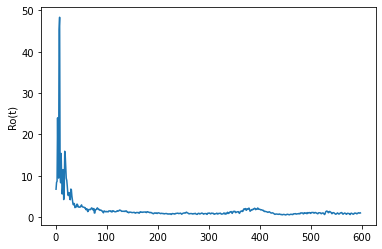

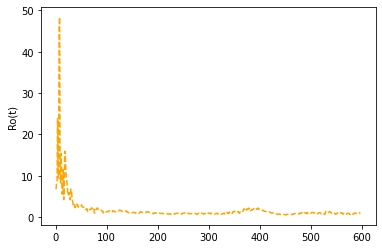

In [74]:
plt.ylabel('Ro(t)')
plt.plot(indices,plot_points)
plt.show()
plt.ylabel('Ro(t)')
plt.plot(indices,scipy_solutions,'--',color = 'orange',alpha=1.0)
plt.show()

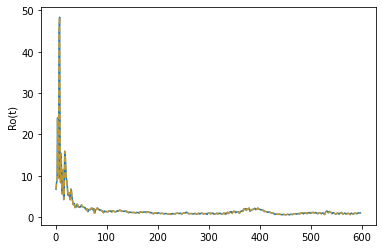

In [75]:
# Overlaying the plots on one another
plt.ylabel('Ro(t)')
plt.plot(indices,plot_points)
plt.plot(indices,scipy_solutions,'--',color = 'orange',alpha=0.7)
plt.show()

- Couldnt find any visible difference between the plots Ro(t) from the values computed using cholesky and scipy.optimize

In [76]:
# Check if Ro(t) computed from cholesky and scipy are the same
# Computing the absolute difference between the two summing and averaging up
error = 0.0
for i in range(len(indices)):
    error += np.abs(scipy_solutions[i] - plot_points[i] )
    #print(str(scipy_solutions[i]) + "    ;;;; " + str(plot_points[i]) + ",,,," + str(scipy_sol_error[i])) 
print("Average error = " + str(error/len(indices)))


Average error = 1.1834940249103009e-15


The average error is very small (10^-15). The solutions obtained using the cholesky factorization based solver and builtin solver is almost equal to each other.



### Reason


Zooming into the 'Ro(t) vs t' plot from t=100 onwards and t=500 and t=550 onwards

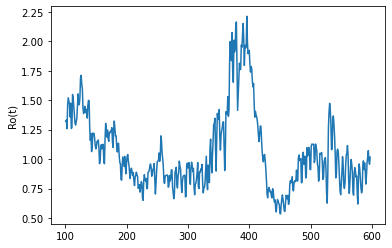

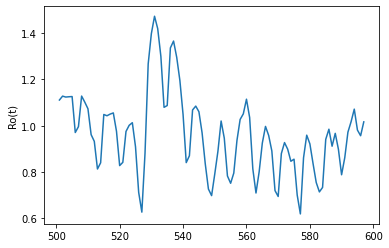

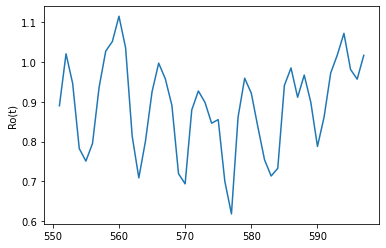

In [82]:
plt.ylabel('Ro(t)')
plt.plot(indices[100:],plot_points[100:])
plt.show()

plt.ylabel('Ro(t)')
plt.plot(indices[500:],plot_points[500:])
plt.show()

plt.ylabel('Ro(t)')
plt.plot(indices[550:],plot_points[550:])
plt.show()



- We can see a huge peak( Ro(t) > 1 ) in the range t = 300-500 and t=100-200 which is in agreement with the peaks in the I(t) graph. There is an exponential increase in infection spread.

- Towards the end the graph rises above 1.0 for some time steps.
- Upon manual observation of values of Ro(t) towards the end (> 500 th day ) we observe it is bounded above by 1.1


- We cant clearly tell whether the pandemic has passed but taking into account the majority behaviour towards the end (Ro< 1)
  we could say that the pandemic is under control as of October 2020
- The peaks has already passed as of the $\approx$ 450th day


## **Question : 2** 


**Steepest Descent and Newton's Line Search Methods**


1. Find the minima $x^*$ for the given functions $f_1(x)$ and  $f_2(x)$ using your own implementation of Steepest Descent. Compute the step lenght by implementing the backtracking algorithm (Algorithm 3.1 Nocedal and Wright) with $\rho = 0.9$ and $c = 10^{-4}$. **[1.5 Points]**

2. Find the minima $x^*$ for the given functions $f_1(x)$ and  $f_2(x)$ using your own implementation of Newton's Method. **[1 Point]**

Notes:
1. Run both algorithms for two initial guesses. i. $x_0=(2,0)$ and ii. $x_0=(2,2)$
2. Stop iterations when $||x_{k+1} - x_{k}||_2^2 < 10^{-5}$
3. For each case report the solution and the number of iterations to converge. Also comment on the reported number of iterations.
4. Show the function contour plot and the iterates {$x_k$} including the solution.

Consider the following quadratic functions:
1. $f_1(x) = \frac{1}{2} x^T A_1 x $
  
  where 
$A_1 = 
  \begin{pmatrix}
  1 & 0 \\
  0 & 1 \\
  \end{pmatrix}$

2. $f_2(x) = \frac{1}{2} x^T A_2 x $
  
  where 
$A_2 = 
  \begin{pmatrix}
  10 & 8 \\
  8 & 10 \\
  \end{pmatrix}$



In [1]:
# Some Helper functions 
def squared_norm(x):
    x_val = np.float64(x[0][0])
    y_val = np.float64(x[1][0])
    return x_val*x_val + y_val*y_val

def norm(x):
    return np.sqrt(squared_norm(x))

def get_unit_vector(x):
    norm_value = norm(x)
    if norm_value == np.float64(0.0):
        return x
    return (x/norm_value).copy()

In [2]:
# Definition of the functions,
# The Jacobians  and the hessian

def f1(x,y):

    # x,y  = Elements of 2*1 vector
    vec = np.array([[x],[y]])
    A = np.array([[1,0],[0,1]])
    h = np.matmul(vec.T,A)
    return 0.5*np.matmul(h,vec)

def f2(x,y):
    
    # x,y  = Elements of 2*1 vector
    vec = np.array([[x],[y]])
    A = np.array([[10,8],[8,10]])
    h = np.matmul(vec.T,A)
    return 0.5*np.matmul(h,vec)


def gradient_f1(x):
    
    # x = Input 2*1 vector
    x_value = np.float64(x[0][0])
    y_value = np.float64(x[1][0])
    return np.array([[x_value],[y_value]])

def gradient_f2(x):
    # x =  2*1 vector
    x_value = np.float64(x[0][0])
    y_value = np.float64(x[1][0])
    return np.array([[10*x_value + 8 *y_value],[10*y_value + 8 * x_value]])

def hessian_f1(x):
    # x =  2*1 vector
    return np.array([[1,0],[0,1]])

def hessian_f2(x):
    # x =  2*1 vector
    return np.array([[10,8],[8,10]])

In [3]:
def steepest_descent(initial_point,function='f1'):
    '''
        Arguments
            - initial_point = 2*1 vector specifying the initial point.
            - function = String to refer to the function which needs to be optimized.
        
    '''
    fun = f1 if function == 'f1' else f2
    gradient_fun = gradient_f1 if function == 'f1' else gradient_f2

    current_point = initial_point.copy()
    c = 0.0001
    rho = 0.9
    iterations = 0
    iterates = []

    iterates.append(current_point)
    while True:        
        
        iterations += 1
        gradient = gradient_fun(current_point)
        # Direction of p should be opposite to the direction of the gradient
        p = -get_unit_vector(gradient)       

        # Intial step size     
        alpha  = np.float64(1.0)
        previous_point = current_point.copy() 
        
        
        break_inner_loop = False
        current_x = np.float64(current_point[0][0])
        current_y = np.float64(current_point[1][0])
        current_function_value = np.float64(fun(current_x,current_y).squeeze()) 
        
        
        while not break_inner_loop:
            
            new_point = current_point + alpha*p

            new_x = np.float64(new_point[0][0])
            new_y = np.float64(new_point[1][0])

            # Calculate the terms in the Taylor Series Approximation.
            new_function_value = np.float64(fun(new_x,new_y).squeeze())
            increment_value = np.float64(((c*alpha)*np.dot(gradient.T,p)).squeeze())

            # Decreasing the step size until sufficient decrease
            if((new_function_value > (current_function_value + increment_value))):
                alpha = alpha * rho
            else:
                break_inner_loop = True
     

        # Perform descent using the step size computed
        new_point = current_point + alpha*p
        current_point = new_point.copy()
        iterates.append(current_point)
        # Condition for stopping 
        if np.linalg.norm(current_point-previous_point) < 0.00001:
            break
    return iterations,iterates


In [10]:
def newtons_method(initial_point,function = 'f1'):
    
    '''
        Arguments
            - initial_point = 2*1 vector specifying the initial point.
            - function = String to refer to the function which needs to be optimized.
        
    '''

    fun = f1 if function == 'f1' else f2
    gradient_fun = gradient_f1 if function == 'f1' else gradient_f2
    hessian_fun = hessian_f1 if function =='f1' else hessian_f2   # Required for calculating the step's direction
    

    current_point = initial_point.copy()
    iterations = 0
    iterates = []
    iterates.append(current_point)


    # For performing the line search 
    c = 0.0001
    rho = 0.9

    while True:        
        iterations+=1
        gradient = gradient_fun(current_point)
        hessian = hessian_fun(current_point)

        # Step Direction in Newtons Method
        m = np.matmul(np.linalg.inv(hessian),gradient)
        p = -m
        
        break_inner_loop = False
        
        # Initial Step Size
        alpha  = np.float64(1.0)
 
        current_x = np.float64(current_point[0][0])
        current_y = np.float64(current_point[1][0])
        current_function_value = np.float64(fun(current_x,current_y).squeeze()) 
        
        while not break_inner_loop:
            new_point = current_point + alpha*p
            new_x = np.float64(new_point[0][0])
            new_y = np.float64(new_point[1][0])
           
           
            # Calculating the taylor Series Approximation
            new_function_value = np.float64(fun(new_x,new_y).squeeze())
            increment_value = np.float64(((c*alpha)*np.dot(gradient.T,p)).squeeze())
            second_order_term = (c*(alpha*alpha/2)*(np.matmul(np.matmul(p.T,hessian),p))).squeeze()
            increment_value += np.float64(second_order_term)


            # Determining the  appropirate stp size
            if((new_function_value > (current_function_value + increment_value))):
                alpha = alpha * rho
            else:
                break_inner_loop = True
      
        
        previous_point = current_point.copy() 
        # Perform the descent
        new_point = current_point + alpha*p
        current_point = new_point.copy()
        iterates.append(current_point)
        if np.linalg.norm(current_point-previous_point) < 0.00001:
            break
    
    return iterations,iterates

In [11]:
# Plot the Contour Plots
def plot_contour(function,iterations,iterates,title = 'Contour Plot'):

    if function == 'f1':
        fun = f1
    else:
        fun = f2

    res = 1000
    x_values = np.linspace(2.1,-2.1,res)
    y_values = np.linspace(2.1,-2.1,res)
    X,Y = np.meshgrid(x_values,y_values)

    Z = np.zeros((res,res))
    for i in range(len(X[0])):
        for j in range(len(Y[:,0])):
            z_value = fun(X[0,i],Y[j,0])
            Z[i][j] = z_value
    
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(X, Y, Z)
    fig.colorbar(cp) 
    ax.set_title(title)
    plt.plot(iterates[0][0,0],iterates[0][1,0],'ro')
    for i in range(1,len(iterates)):
        plt.arrow(iterates[i-1][0,0],iterates[i-1][1,0],dx = iterates[i][0,0] - iterates[i-1][0,0] ,dy = iterates[i][1,0] - iterates[i-1][1,0],width=0.01,head_width = 0.09)
    plt.plot(iterates[len(iterates)-1][0,0], iterates[len(iterates)-1][1,0],'go',linewidth=0.1)
    plt.show()


##### Function f1(x)

Initial Point = [[2],[0]]
----------------------------
Steepest Descent Solution = [[0.]
 [0.]]
Iterations taken for Steepest Descent= 3


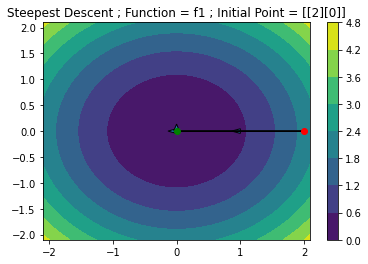

Newtons Method Solution = [[0.]
 [0.]]
Iterations taken for Newtons Method = 2


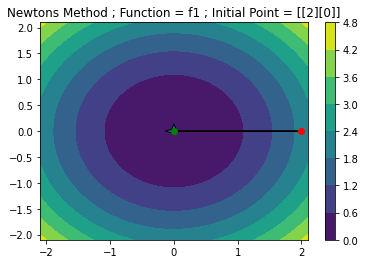

In [12]:
initial_point = np.array([[2],[0]])

print("Initial Point = [[2],[0]]")
print("----------------------------")
iterations_steep_f1 , iterates_steep_f1 = steepest_descent(initial_point,'f1')
iterations_newton_f1 , iterates_newton_f1 = newtons_method(initial_point,'f1')
print("Steepest Descent Solution = " + str(iterates_steep_f1[-1]))
print("Iterations taken for Steepest Descent= " + str(iterations_steep_f1))
plot_contour('f1',iterations_steep_f1,iterates_steep_f1,title='Steepest Descent ; Function = f1 ; Initial Point = [[2][0]]' )
print("Newtons Method Solution = " + str(iterates_newton_f1[-1]))
print("Iterations taken for Newtons Method = " + str(iterations_newton_f1))
plot_contour('f1',iterations_newton_f1,iterates_newton_f1,title='Newtons Method ; Function = f1 ; Initial Point = [[2][0]]')


Initial Point = [[2],[2]]
----------------------------
Steepest Descent Solution = [[2.62421098e-06]
 [2.62421098e-06]]
Iterations taken for Steepest Descent= 72


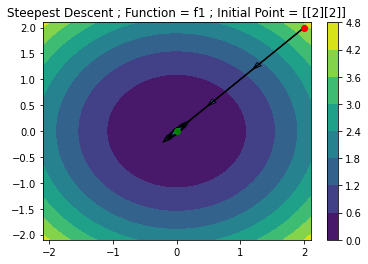

Newtons Method Solution = [[0.]
 [0.]]
Iterations taken for Newtons Method =2


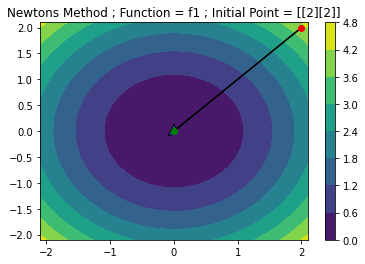

In [13]:
initial_point = np.array([[2],[2]])

print("Initial Point = [[2],[2]]")
print("----------------------------")
iterations_steep_f1 , iterates_steep_f1 = steepest_descent(initial_point,'f1')
iterations_newton_f1 , iterates_newton_f1 = newtons_method(initial_point,'f1')
print("Steepest Descent Solution = " + str(iterates_steep_f1[-1]))
print("Iterations taken for Steepest Descent= " + str(iterations_steep_f1))
plot_contour('f1',iterations_steep_f1,iterates_steep_f1,title='Steepest Descent ; Function = f1 ; Initial Point = [[2][2]]' )
print("Newtons Method Solution = " + str(iterates_newton_f1[-1]))
print("Iterations taken for Newtons Method =" + str(iterations_newton_f1))
plot_contour('f1',iterations_newton_f1,iterates_newton_f1,title='Newtons Method ; Function = f1 ; Initial Point = [[2][2]]')


##### Function f2(x)

Initial Point = [[2],[0]]
----------------------------
Steepest Descent Solution = [[-2.91584190e-06]
 [-2.91738507e-06]]
Iterations taken for Steepest Descent= 90


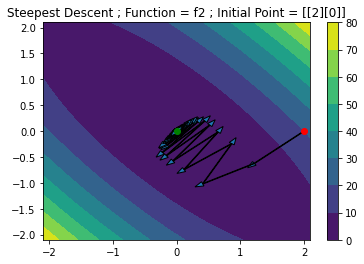

Newtons Method Solution = [[9.86076132e-32]
 [0.00000000e+00]]
Iterations taken for Newtons Method =2


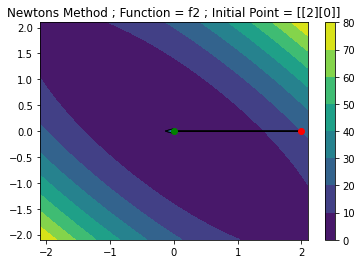

In [104]:
initial_point = np.array([[2],[0]])

print("Initial Point = [[2],[0]]")
print("----------------------------")
iterations_steep_f2 , iterates_steep_f2 = steepest_descent(initial_point,'f2')
iterations_newton_f2 , iterates_newton_f2 = newtons_method(initial_point,'f2')
print("Steepest Descent Solution = " + str(iterates_steep_f2[-1]))
print("Iterations taken for Steepest Descent= " + str(iterations_steep_f2))
plot_contour('f2',iterations_steep_f2,iterates_steep_f2,title='Steepest Descent ; Function = f2 ; Initial Point = [[2][0]]' )
print("Newtons Method Solution = " + str(iterates_newton_f2[-1]))
print("Iterations taken for Newtons Method =" + str(iterations_newton_f2))
plot_contour('f2',iterations_newton_f2,iterates_newton_f2,title='Newtons Method ; Function = f2 ; Initial Point = [[2][0]]')


Initial Point = [[2],[2]]
----------------------------
Steepest Descent Solution = [[2.62421098e-06]
 [2.62421098e-06]]
Iterations taken for Steepest Descent= 72


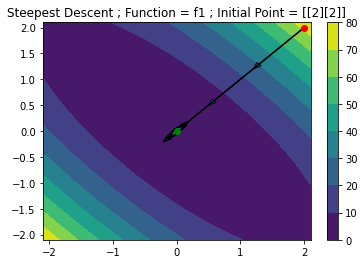

Newtons Method Solution = [[0.]
 [0.]]
Iterations taken for Newtons Method =2


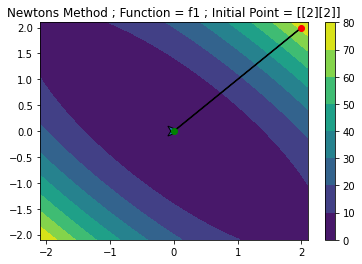

In [105]:
initial_point = np.array([[2],[2]])

print("Initial Point = [[2],[2]]")
print("----------------------------")
iterations_steep_f2 , iterates_steep_f2 = steepest_descent(initial_point,'f2')
iterations_newton_f2 , iterates_newton_f2 = newtons_method(initial_point,'f2')
print("Steepest Descent Solution = " + str(iterates_steep_f2[-1]))
print("Iterations taken for Steepest Descent= " + str(iterations_steep_f2))
plot_contour('f2',iterations_steep_f2,iterates_steep_f2,title='Steepest Descent ; Function = f1 ; Initial Point = [[2][2]]' )
print("Newtons Method Solution = " + str(iterates_newton_f2[-1]))
print("Iterations taken for Newtons Method =" + str(iterations_newton_f2))
plot_contour('f2',iterations_newton_f2,iterates_newton_f2,title='Newtons Method ; Function = f1 ; Initial Point = [[2][2]]')


$$
f_1(x) = \frac{1}{2} x^T A_1 x 
  
$$
$$
A_1 = 
  \begin{pmatrix}
  1 & 0 \\
  0 & 1 \\
  \end{pmatrix}
$$

| Initial Point     | Iterations(Steepest Descent) | Minima(Steepest Descent) | Iterations (Newtons Method) | Minima (Newtons Method) | 
| ----------- | ----------- |-----| ----- | ----- | 
| (2,2)      | 72      |   $(2*10^{-6},2*10^{-6})$  | 2 | (0.0,0.0) | 
| (2,0)  | 3       |  (0.0,0.0)  | 2 | (0.0,0.0) | 



$$f_2(x) = \frac{1}{2} x^T A_2 x 
  
$$
$$ A_2 = 
  \begin{pmatrix}
  10 & 8 \\
  8 & 10 \\
  \end{pmatrix} $$


| Initial Point     | Iterations(Steepest Descent) | Minima(Steepest Descent) | Iterations (Newtons Method) | Minima (Newtons Method) | 
| ----------- | ----------- |-----| ----- | ----- | 
| (2,2)      | 72      |   $(2*10^{-6},2*10^{-6})$  | 2 | (0.0,0.0) | 
| (2,0)  | 90       | $(-2*10^{-6},-2*10^{-6})$   | 2 | ($9*10^{-32}$,0.0) | 



# **Question : 3**

**Rosenbrock function**

Use the steepest descent and Newtons algorithms using the backtracking line search to minimize the classic Rosenbrock function. Set the initial step length to 1. At each iteration store the step lengths used by each method and make plots. Show the step lengths taken and iterates as plots. Do these for a start point of search $x_0 = [1.2, 1.2]^T$ and then for the starting point $x_0 = [-1.2, 1]^T$ **[1 Point]**

1. Plot the convergence of the iterates and the objective function value. Evaluate the rate of convergence. **[0.5 Points]**

2. Call built-in functions for steepest descent and newton’s method, and show the results for the above. Compare and evaluate your program. Compare the run-time of your program and built-in function. Is there a difference? Why or why not? **Hint**: Jacobians! **[1 Point]**